In [1]:
from torchvision.models import resnet18
from torchvision.datasets import CIFAR100
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
import torch
from torch.backends import cudnn
import random
import numpy as np
from torch.optim import Adam,SGD
from torch.optim import lr_scheduler

%matplotlib inline
import matplotlib.pyplot as plt

cudnn.benchmark = False
cudnn.deterministic = True
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
class ACC(object):
    def __init__(self):
        self.current_acc=0.0
        self.avg_acc=0.0
        self.count=0
    def update(self,current_acc):
        self.avg_acc*=self.count
        self.current_acc=current_acc
        self.avg_acc+=current_acc
        self.count+=1
        self.avg_acc=self.avg_acc/self.count
        
class Loss(object):
    def __init__(self):
        self.current_loss=0.0
        self.avg_loss=0.0
        self.count=0
    def update(self,current_loss):
        self.avg_loss*=self.count
        self.current_loss=current_loss
        self.avg_loss+=current_loss
        self.count+=1
        self.avg_loss=self.avg_loss/self.count

In [3]:
def acc_(feature,label):
    pre=feature.argmax(1)
    return float((pre==label).sum().item())/pre.size(0)

In [4]:
class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [5]:
def getmodel():
    size_size=96
    model=resnet18()
    pre_weight=torch.load('/raid/lcq/premdoel_pytorch/resnet18-5c106cde.pth')
    model.load_state_dict(pre_weight)
    model.avgpool = nn.AvgPool2d(size_size//32)
    model.fc = nn.Linear(512 , 100)
    return model,size_size


In [6]:
def train_test(model,use_center_loss=False,size_size=224):
    transform=transforms.Compose([
    transforms.Resize(size_size),
    transforms.ToTensor(),
    transforms.Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225])
    ])
    data_train=CIFAR100('./data',download=True,transform=transform)
    data_test=CIFAR100('./data',download=True,train=False,transform=transform)
    data_loader=DataLoader(data_train,batch_size=128,num_workers=8,shuffle=True)
    test_loader=DataLoader(data_test,batch_size=64,num_workers=8)
    model_ability={
        'train_loss':[],
        'test_loss':[],
        'train_acc':[],
        'test_acc':[],
        'test_max_acc':0.0
    }
    aCC=ACC()
    lOSS=Loss()
    criterion=nn.CrossEntropyLoss()
    if use_center_loss:
        if torch.cuda.is_available():
            use_gpu=True
        else:
            use_gpu=False
        criterion_center=CenterLoss(num_classes=100, feat_dim=100, use_gpu=use_gpu)
        optimizer_centloss = Adam(criterion_center.parameters(), lr=1e-3)
        weight_cent=1
        if torch.cuda.is_available():
            criterion_center.cuda()
    if torch.cuda.is_available():
        model.cuda()
        criterion.cuda()
    optimizer=Adam(model.parameters(),lr=1e-3,weight_decay=5e-04)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    freq=0
    test_max=0
    for epoch in range(40):
        model.train()
        if epoch >0:
            scheduler.step()
        for (img,label) in data_loader:
            if torch.cuda.is_available():
                img=img.cuda()
                label=label.cuda()
            feature=model(img)
            if not use_center_loss:
                loss=criterion(feature,label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                loss_cls=criterion(feature,label)
                loss_cen=criterion_center(feature,label)
                loss_cen*=weight_cent
                loss=loss_cls+loss_cen
                optimizer.zero_grad()
                optimizer_centloss.zero_grad()
                loss.backward()
                optimizer.step()
                for param in criterion_center.parameters():
                    param.grad.data *= (1. / weight_cent)
                optimizer_centloss.step()
            acc=acc_(feature,label)
            aCC.update(acc)
            lOSS.update(loss.item())
            model_ability['train_loss'].append(lOSS.avg_loss)
            model_ability['train_acc'].append(aCC.avg_acc)
            del img
            del label
            del feature
            freq+=1
        if epoch >0 and epoch %2==0 or (epoch+1)==100:
            test_acc=ACC()
            test_loss=Loss()
            model.eval()
            for (img,label) in test_loader:
                if torch.cuda.is_available():
                    img=img.cuda()
                    label=label.cuda()
                feature=model(img)
                loss=criterion(feature,label)
                acc=acc_(feature,label)
                test_acc.update(acc)
                test_loss.update(loss.item())
                del img
                del label
                del feature
            if test_acc.avg_acc>=test_max:
                test_max=test_acc.avg_acc
            train_log='TRAIN: [{}/{}] LOSS:[{:.7f}/{:.7f}] ACC:[{:.7f}/{:.7f}]'.format(freq,epoch,lOSS.current_loss,lOSS.avg_loss,aCC.current_acc,aCC.avg_acc)
            test_log='TEST>>: [{}/{}] LOSS:[{:.7f}] ACC:[{:.7f}] MAX TEST ACC:{:.7f}'.format(freq,epoch,test_loss.avg_loss,test_acc.avg_acc,test_max)
            model_ability['test_loss'].append(test_loss.avg_loss)
            model_ability['test_acc'].append(test_acc.avg_acc)
            model_ability['test_max_acc']=test_max
            print(train_log)
            print(test_log)
            del test_acc
            del test_loss
    del model
    del optimizer
    del scheduler
    return model_ability


In [7]:
model_without_center_loss,size_size=getmodel()
model_ability_without_center_loss=train_test(model_without_center_loss,size_size=size_size)

Files already downloaded and verified
Files already downloaded and verified
TRAIN: [1173/2] LOSS:[1.5517128/1.3537924] ACC:[0.6125000/0.6157302]
TEST>>: [1173/2] LOSS:[1.5708763] ACC:[0.5749403] MAX TEST ACC:0.5749403
TRAIN: [1955/4] LOSS:[0.6624342/1.1371590] ACC:[0.8000000/0.6714538]
TEST>>: [1955/4] LOSS:[1.5508197] ACC:[0.5835987] MAX TEST ACC:0.5835987
TRAIN: [2737/6] LOSS:[0.9312795/0.9941949] ACC:[0.7375000/0.7100663]
TEST>>: [2737/6] LOSS:[1.5911902] ACC:[0.5885748] MAX TEST ACC:0.5885748
TRAIN: [3519/8] LOSS:[0.7851602/0.8905930] ACC:[0.7375000/0.7388836]
TEST>>: [3519/8] LOSS:[1.6549310] ACC:[0.5856887] MAX TEST ACC:0.5885748
TRAIN: [4301/10] LOSS:[0.5241329/0.8121816] ACC:[0.8375000/0.7610341]
TEST>>: [4301/10] LOSS:[1.6266432] ACC:[0.5915605] MAX TEST ACC:0.5915605
TRAIN: [5083/12] LOSS:[0.0742568/0.7021396] ACC:[0.9875000/0.7939821]
TEST>>: [5083/12] LOSS:[1.4002488] ACC:[0.6609275] MAX TEST ACC:0.6609275
TRAIN: [5865/14] LOSS:[0.4219657/0.6198838] ACC:[0.8875000/0.8187409

In [8]:
model_with_center_loss,size_size=getmodel()
model_ability_with_center_loss=train_test(model_with_center_loss,True,size_size)

Files already downloaded and verified
Files already downloaded and verified
TRAIN: [1173/2] LOSS:[15.5569048/40.3195978] ACC:[0.0250000/0.0177017]
TEST>>: [1173/2] LOSS:[4.3527585] ACC:[0.0316481] MAX TEST ACC:0.0316481
TRAIN: [1955/4] LOSS:[8.7327480/28.5478092] ACC:[0.1250000/0.0464466]
TEST>>: [1955/4] LOSS:[4.0554307] ACC:[0.1363455] MAX TEST ACC:0.1363455
TRAIN: [2737/6] LOSS:[6.6914763/22.2585030] ACC:[0.5250000/0.1363874]
TEST>>: [2737/6] LOSS:[3.7288463] ACC:[0.3791799] MAX TEST ACC:0.3791799
TRAIN: [3519/8] LOSS:[4.8501282/18.4733743] ACC:[0.6750000/0.2523036]
TEST>>: [3519/8] LOSS:[3.5058263] ACC:[0.4959196] MAX TEST ACC:0.4959196
TRAIN: [4301/10] LOSS:[4.6238008/15.9313115] ACC:[0.8875000/0.3544960]
TEST>>: [4301/10] LOSS:[3.2963056] ACC:[0.5827030] MAX TEST ACC:0.5827030
TRAIN: [5083/12] LOSS:[2.8143365/13.9422798] ACC:[0.9625000/0.4434930]
TEST>>: [5083/12] LOSS:[2.9207994] ACC:[0.6871019] MAX TEST ACC:0.6871019
TRAIN: [5865/14] LOSS:[2.3105376/12.3959113] ACC:[1.0000000/0

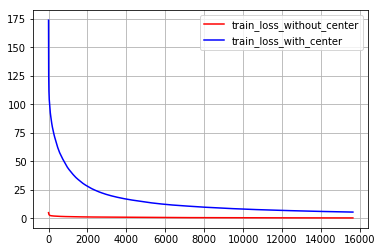

In [14]:
plt.grid(True)
plt.plot(model_ability_without_center_loss['train_loss'],color='red')
plt.plot(model_ability_with_center_loss['train_loss'],color='blue')
plt.legend(['train_loss_without_center','train_loss_with_center'])
plt.show()

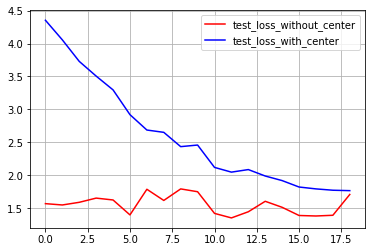

In [15]:
plt.grid(True)
plt.plot(model_ability_without_center_loss['test_loss'],color='red')
plt.plot(model_ability_with_center_loss['test_loss'],color='blue')
plt.legend(['test_loss_without_center','test_loss_with_center'])
plt.show()

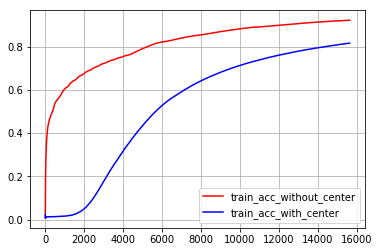

In [16]:
plt.grid(True)
plt.plot(model_ability_without_center_loss['train_acc'],color='red')
plt.plot(model_ability_with_center_loss['train_acc'],color='blue')
plt.legend(['train_acc_without_center','train_acc_with_center'])
plt.show()

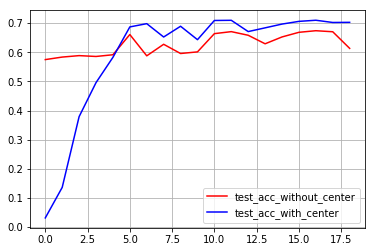

In [17]:
plt.grid(True)
plt.plot(model_ability_without_center_loss['test_acc'],color='red')
plt.plot(model_ability_with_center_loss['test_acc'],color='blue')
plt.legend(['test_acc_without_center','test_acc_with_center'])
plt.show()

In [18]:
print('test_max_acc_without_center:',model_ability_without_center_loss['test_max_acc'])
print('test_max_acc_with_center:',model_ability_with_center_loss['test_max_acc'])

test_max_acc_without_center: 0.6740644904458599
test_max_acc_with_center: 0.7099920382165604
